# Simulated Faraday Rotation

In [15]:
import numpy as np

import matplotlib
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib import gridspec
import RMtools_1D
from RMtools_1D import do_RMsynth_1D as rm1d
from RMtools_1D import do_RMclean_1D as rmclean

print(RMtools_1D.__version__)

1.4.7


### Relations of variables
$\omega \times t $\
$\nu = \omega/2\pi $\
$T = 1/\nu $\
$T = 2\pi/\omega$

$k \times z$\
$Z = 2\pi/k$

$E_1 = E_0 cos(\theta)$\
$E_2 = E_0 sin(\theta)$

$\theta = tan^{-1}(E_2/E_1)$

$E_x = E_1sin(\omega t - k z)$\
$E_y = E_2sin(\omega t - k z + \phi)$

Fundamental quantities:

$E_0$ : amplitude\
$\theta$ : linear polarization angle\
$\phi$ : phase difference


RM = $\frac {e^3} {2 \pi m_e^2 c^4}  \int n_e B_{||} dl$

$\chi_{obs}=\chi_{src}+RM\lambda^2$

### Set some physical parameters to determine the Faraday rotation

### Question: What happens when you add multiple RM components?

In [143]:
#constants
e=4.8E-10 #esu.
me=9.1094E-28 #g
c=3E10 #cm/s

#physical parameters
ne = 0.1 #cm-3
B_G  = -5e-6 #G
dl = 100 #pc
ds = 3.086e+18 * dl #cm/pc -> cm
nu=1000E6 #Hz

k = e**3 / (2 * np.pi * me**2 * (c)**4)  
RM = k * ne * B_G * ds * 100**2 #rad/cm^2 -> rad/m^2
RMs = [RM]

#add another RM component
#RM2 = RM+0.5*RM
#RMs = [RM, RM2]

for RM in RMs:
    print(f"RM = {RM:0.5f} rad/m^2")



RM = -40.40594 rad/m^2


Set the initial parameters of the radiation\
$\phi$ = initial phase difference between Ex and Ex\
$\theta$ = initial polarization angle

In [ ]:
#inputs
phi_deg = 0 #phase difference between Ex and Ey, 0 for linear pol
theta_deg = 24 #pol position angle at the source


In [145]:
def getIQUV(theta_deg, phi_deg, RMs, nu, showFig=False):
    
    omega = nu * (2*np.pi)
    wave = c/nu/100
    phi = np.deg2rad(phi_deg)
    theta = np.deg2rad(theta_deg)
    alpha = -0.7
    S_nu = np.power(nu,alpha)/1e-8
    #S_nu=1
    E1 = np.cos(theta)
    E2 = np.sin(theta)
    coord_max = max(E1,E2)

    T = 1/nu # Time-Period of the wave
    ntCycles=1
    n_t = ntCycles*100
    t_T = np.linspace(0,ntCycles*T,n_t)
    t=t_T 
    
    k = 2*np.pi/wave
    
    for j in range(0,len(RMs)):
        chi_rot = RMs[j]*wave*wave
        chi_rot_deg = np.rad2deg(chi_rot)
    
        #z=constant since we are observing at a fixed position
        z=0
        Ex = S_nu*E1*np.sin(omega*t - k*z)/coord_max/1e-3
        Ey = S_nu*E2*np.sin(omega*t - k*z + phi) /coord_max/1e-3
        rot = ([(np.cos(chi_rot),-np.sin(chi_rot)),(np.sin(chi_rot),np.cos(chi_rot))])
        EXY = ([Ex, Ey])
        EXY_rot = np.matmul(rot, EXY)

        Ex_rot = EXY_rot[0][1:98]
        Ey_rot = EXY_rot[1][1:98]
        chi_obs = np.rad2deg(np.arctan2(Ey_rot,Ex_rot)[-1])
        chi_src_m = (chi_rot_deg + chi_obs)%360

        i = (np.mean(Ex_rot)*np.mean(Ex_rot)) + (np.mean(Ey_rot)*np.mean(Ey_rot))
        q = (np.mean(Ex_rot)*np.mean(Ex_rot)) - (np.mean(Ey_rot)*np.mean(Ey_rot))
        u = 2*np.mean(Ex_rot)*np.mean(Ey_rot)*np.cos(phi)
        v = 2*np.mean(Ex_rot)*np.mean(Ey_rot)*np.sin(phi)       
        
        if(j==0):
            I = i
            Q = q
            U = u
            V = v
        if(j>0):
            I = I+i
            Q = Q+q
            U = U+u
            V = V+v
    
    chi_QU = 0.5*np.arctan2(U,Q)
    
    if(showFig):
        fig = plt.figure(figsize=(4,4))

        ax = fig.add_subplot(1,1,1, adjustable='box', aspect=1)
        #ax.set_xlim(-1000,1000)
        #ax.set_ylim(-1000,1000)
        ax.plot(Ex,Ey,label="original")
        chi_src = np.rad2deg(np.arctan2(Ey,Ex)[-1])

        ax.plot(Ex_rot,Ey_rot,label="rotated")
        chi_obs = np.rad2deg(np.arctan2(Ey_rot,Ex_rot)[-1])
        chi_src_m = (chi_rot_deg + chi_obs)%360
        ax.legend()
        plt.show()

    
    '''
    print(f"wavelength: {wave:0.2f} m")
    print(f"Time range ({ntCycles} periods): {max(t_T)} s")   
    print(f"chi_src ={chi_src_m:0.2f}")
    print(f"chi_obs ={chi_obs:0.2f}")
    print(f"chi_rot ={chi_rot_deg:0.2f}")
    print(f"chi_QU = {np.rad2deg(chi_QU):0.2f}")
    '''
    
    I = np.array(I)
    Q = np.array(Q)
    U = np.array(U)
    V = np.array(V)
    return I, Q, U, V

### Set the frequency coverage of your observations

In [146]:
chan_width = 0.1 #MHz
nu1 = 600 #MHz
nu2 = 850 #MHz

numchan = int((nu2-nu1)/chan_width)
nus1 = np.linspace(nu1*1E6, nu2*1E6, numchan+1)
print(f"Num channels (band 1): {numchan}")

chan_width = 1.0 #MHz
nu1 = 800 #MHz
nu2 = 1100 #MHz
numchan = int((nu2-nu1)/chan_width)
print(f"Num channels (band 2): {numchan}")
nus2 = np.linspace(nu1*1E6, nu2*1E6, numchan+1)

nus = np.concatenate((nus1, nus2),axis=0)
#nus=nus2

I = []
Q = []
U = []
V = []

for nu in nus:

    i, q, u, v = getIQUV(theta_deg, phi_deg, RMs, nu, showFig=False)
    
    I.append(i)
    Q.append(q)
    U.append(u)
    V.append(v)



Num channels (band 1): 2500
Num channels (band 2): 300


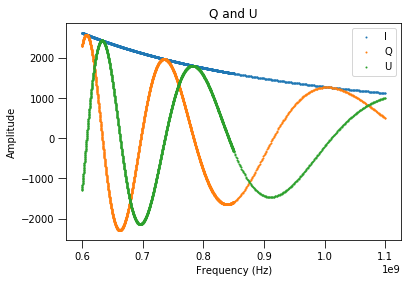

In [152]:
PI = np.sqrt(np.array(Q)**2+np.array(U)**2)
plt.title("Q and U")
plt.scatter(nus,I, label="I",s=1)
plt.scatter(nus,Q, label="Q",s=1)
plt.scatter(nus,U, label="U",s=1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()


In [153]:
#Make a data array for the RM-Synthesis

error = np.ones(len(Q))*0.01
data=[nus,np.array(I),Q,U,error,error,error]
#np.savetxt("spectrum.dat", np.transpose(data))

### Faraday Rotation Measure Synthesis

$F(\phi) = \sum\limits_{j=1}^{N} w_j \frac {\tilde P_j} {I_j} e^{-2i\phi(\lambda_j^2-\lambda_0^2)}$

$\tilde P(\lambda^2) = Q(\lambda^2) + iU(\lambda^2)$

$N=$ num of frequency channels

$\phi=$ Faraday depths

### Question: What is the RMSF? 

### Question: What happens when you add multiple RM components related to this value?

> Trying [freq_Hz, I, Q, U, dI, dQ, dU] ... success.
Successfully read in the Stokes spectra.
Plotting the input data and spectral index fit.
PhiArr = -500.00 to 500.00 by 1.00 (1001 chans).
Weight type is 'variance'.
Calculating 1D RMSF and replicating along X & Y axes.
> RM-synthesis completed in 0.29 seconds.

--------------------------------------------------------------------------------
RESULTS:

FWHM RMSF = 21.67 rad/m^2
Pol Angle = 141.8 (+/-2.689e-06) deg
Pol Angle 0 = 24 (+/-1.219e-05) deg
Peak FD = -40.46 (+/-1.017e-06) rad/m^2
freq0_GHz = 0.7025 
I freq0 = 2110 mJy/beam
Peak PI = 2110 (+/-0.000198) mJy/beam
QU Noise = 0.01 mJy/beam
FDF Noise (theory)   = 0.000198 mJy/beam
FDF Noise (Corrected MAD) = 33.24 mJy/beam
FDF SNR = 1.065e+07 
sigma_add(q) = 0.008309 (+0.01802, -0.002889)
sigma_add(u) = 0.01359 (+0.03649, -0.00708)
Fitted polynomial order = 2 

--------------------------------------------------------------------------------


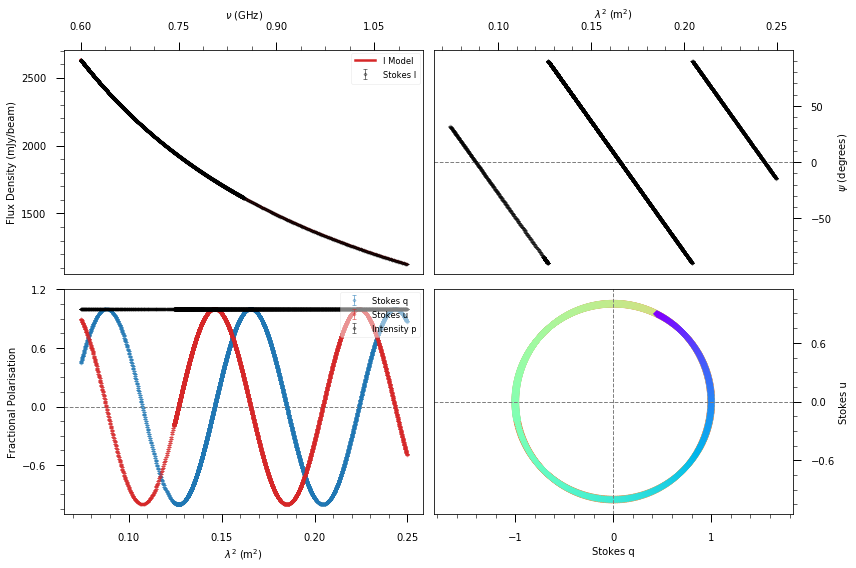

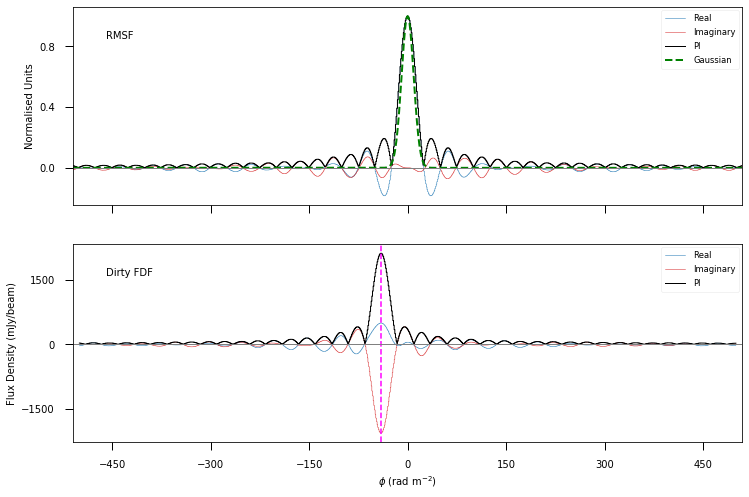

In [149]:
#Run RM-Synthesis using RM-Tools
rmdict, rmdata =rm1d.run_rmsynth(data, units="mJy/beam",verbose=True,showPlots=True,phiMax_radm2=500, dPhi_radm2=1,noStokesI=False )


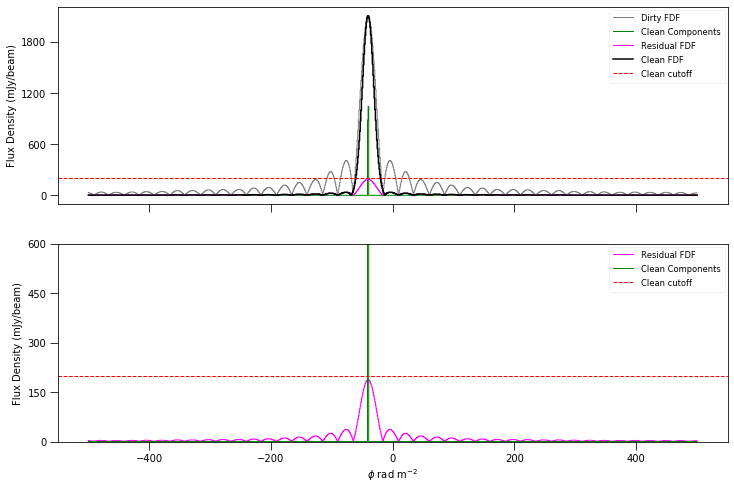

In [150]:
#Run RM-Clean using RM-Tools
cutoff=200
cleanDict, cleanData = rmclean.run_rmclean(rmdict, rmdata, cutoff, showPlots=True)



In [94]:
cleanDict

{'dFDFcorMAD': 21.54346051025584,
 'phiPeakPIfit_rm2': -50.52656736203551,
 'dPhiPeakPIfit_rm2': 1.1373407999285953e-05,
 'ampPeakPIfit': 1497.0597997175296,
 'ampPeakPIfitEff': 1497.0597997172597,
 'dAmpPeakPIfit': 0.0005928257854932858,
 'snrPIfit': 2525294.675689313,
 'indxPeakPIfit': 449.4734326379645,
 'peakFDFimagFit': -805.7322880057684,
 'peakFDFrealFit': 1261.4588809294191,
 'polAngleFit_deg': 163.7161934925521,
 'dPolAngleFit_deg': 1.134437498812741e-05,
 'polAngle0Fit_deg': 113.64648581914366,
 'dPolAngle0Fit_deg': 6.527954718331362e-05,
 'cleanCutoff': 200,
 'nIter': 35,
 'mom2CCFDF': 16.486942291259766,
 'dPhiObserved_rm2': 0.41331293627142657,
 'dAmpObserved': 21.54346051025584,
 'dPolAngleFitObserved_deg': 0.4122578682485884,
 'dPolAngleFit0Observed_deg': 2.3722776257123988}

In [95]:
#Find the non-zero clean components
phiArr = cleanData['phiArr_radm2']
ccArr = cleanData['ccArr']
phiArr[ccArr>0]

array([-72., -71., -70., -68., -51., -50., -40., -32., -30., -29.],
      dtype=float32)